In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  3 03:30:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!unzip DUMB.zip

Streaming output truncated to the last 5000 lines.
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/41076904-8726-4e01-9448-dd036863ddb9___Com.G_TgS_FL 9737.JPG  
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/41bb6805-695e-4c35-854c-ce4ed54388b3___Com.G_TgS_FL 9907.JPG  
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/41f2bcea-5197-46c0-9cae-73724af3a5b8___Com.G_TgS_FL 9812.JPG  
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/420d41c9-ff56-495f-bd7d-ecf157cf4efc___Com.G_TgS_FL 1031.JPG  
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/422f18d4-03d3-410c-97f0-f92590db890a___Com.G_TgS_FL 8085.JPG  
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/42745c34-b8ec-44b1-8107-879222ac07d1___Com.G_TgS_FL 0866.JPG  
  inflating: Tomatoes Diseases Dataset/Dataset Train/Tomato__Target_Spot/42920fd3-0a32-42c8-9341-4d0659cb9e7b___Com.G_TgS_FL 0967.JPG

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [5]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 15
num_classes = 10

In [6]:
data_dir = './Tomatoes Diseases Dataset'

target_size = 1000
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
train_dataset = datasets.ImageFolder(root=f'{data_dir}/Dataset Train', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/Dataset Test', transform=transform)

In [18]:
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

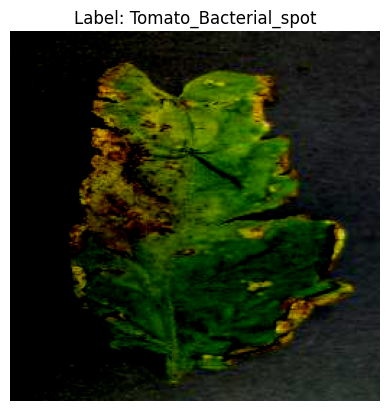

Label index: 0, Label name: Tomato_Bacterial_spot
Image shape: torch.Size([3, 256, 256])


In [9]:
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

example_index = 56
image, label = train_dataset[example_index]

class_name = train_dataset.classes[label]

image_np = image.permute(1, 2, 0).numpy()
plt.imshow(image_np)
plt.title(f'Label: {class_name}')
plt.axis('off')
plt.show()

print(f'Label index: {label}, Label name: {class_name}')
print(f'Image shape: {image.shape}')

In [10]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model = Classifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}')
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():  # Disable gradient calculation for testing
            for test_images, test_labels in test_loader:
                test_outputs = model(test_images)
                test_loss = criterion(test_outputs, test_labels)
                running_test_loss += test_loss.item()

        test_loss = running_test_loss / len(test_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
        test_losses.append(test_loss)

        model.train()
    return train_losses, test_losses

In [13]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

In [14]:
train_losses, test_losses = train(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/15], Train Loss: 0.9664
Epoch [1/15], Test Loss: 0.4902
Epoch [2/15], Train Loss: 0.3271
Epoch [2/15], Test Loss: 0.3562
Epoch [3/15], Train Loss: 0.1598
Epoch [3/15], Test Loss: 0.2624
Epoch [4/15], Train Loss: 0.0746
Epoch [4/15], Test Loss: 0.2630
Epoch [5/15], Train Loss: 0.0444
Epoch [5/15], Test Loss: 0.3136
Epoch [6/15], Train Loss: 0.0334
Epoch [6/15], Test Loss: 0.3357
Epoch [7/15], Train Loss: 0.0418
Epoch [7/15], Test Loss: 0.5180
Epoch [8/15], Train Loss: 0.0365
Epoch [8/15], Test Loss: 0.3484
Epoch [9/15], Train Loss: 0.0166
Epoch [9/15], Test Loss: 0.5541


KeyboardInterrupt: 

In [15]:
torch.save(model, 'disease_detection.pth')

In [17]:
evaluate(model, test_loader)

Accuracy: 88.65%
